## <font color="Greenyellow">Trabajo de Fin Master 2: Modelos ensemble</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Ensemble Learning](#item3)

***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [1]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb
# Modelos
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
import shap
from sklearn.tree import plot_tree

c:\Users\Nitropc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


In [5]:
best_params_rf = joblib.load('data/parametros/r_forest_best_params.pkl')
best_params_xgb = joblib.load('data/parametros/xgb_best_params.pkl')
best_params_rl = joblib.load('data/parametros/r_logistica_best_params.pkl')
best_params_lgb = joblib.load('data/parametros/lgbm_best_params.pkl')

***
<a id="item3"></a>
### <font color="Greenyellow">3. Ensemble Learning (stacking)</font>
[Volver al indice](#item0)

Con calibrado y umbral 0.01

Calibrando modelos base...
1. Inicio del entrenamiento...
... entrenamiento completado.
Evaluando con umbral ajustado: 0.01
2. Generando metricas de evaluacion:
    A. Precisión del modelo: 0.9996
    B. F1 Score: 0.8851
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8556 (Umbral Ajustado)
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.92      0.86      0.89        90

    accuracy                           1.00     56962
   macro avg       0.96      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



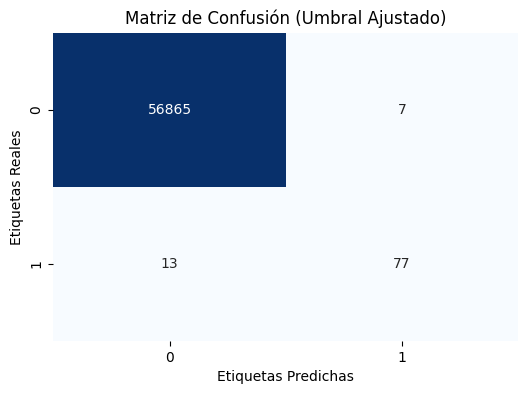

    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8820
    C. AUC: 0.9909
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7889
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       1.00      0.79      0.88        90

    accuracy                           1.00     56962
   macro avg       1.00      0.89      0.94     56962
weighted avg       1.00      1.00      1.00     56962



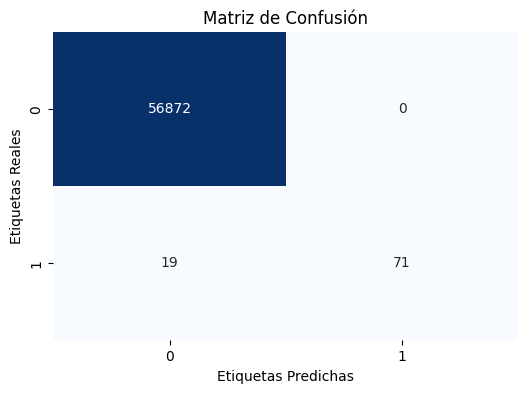

In [6]:
# 1. Definimos los modelos a ensamblar
model_1 = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
model_2 = xgb.XGBClassifier(**best_params_xgb, objective='binary:logistic', use_label_encoder=False, eval_metric='aucpr', verbosity=0)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
model_3 = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=semilla, n_jobs=-1)
model_4 = lgb.LGBMClassifier(**best_params_lgb, objective='binary', random_state=semilla, n_jobs=-1)

# 2. Calibramos los modelos base
print("Calibrando modelos base...")
# RandomForestClassifier
calibrated_rf = CalibratedClassifierCV(model_1, method='isotonic', cv=3, n_jobs=-1)
calibrated_reglog = CalibratedClassifierCV(model_3, method='isotonic', cv=3, n_jobs=-1)
calibrated_xgb = CalibratedClassifierCV(model_2, method='isotonic', cv=3, n_jobs=-1)
calibrated_lgbm = CalibratedClassifierCV(model_4, method='isotonic', cv=3, n_jobs=-1)


# 2. Definimos el meta-modelo
meta_model = meta_model = LogisticRegression(solver='liblinear', random_state=semilla)

# 3. Ensamblamos los modelos instanciando el  StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('rf', calibrated_rf),
                ('xgb_1', calibrated_xgb),
                ('rl_1', calibrated_reglog),
                ('lgbm', calibrated_lgbm)],
    final_estimator=meta_model, cv=3, n_jobs=-1, stack_method='predict_proba')

# 4. Entrenamiento del Ensemble
print("1. Inicio del entrenamiento...")
stacking_model.fit(X_train, y_train)
print("... entrenamiento completado.")

# 5. Evaluación del Ensemble

y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
umbral_recall_optimo = 0.01
y_pred_umbral_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
y_pred_ajustado = (y_pred_proba >= umbral_recall_optimo).astype(int)
print(f"Evaluando con umbral ajustado: {umbral_recall_optimo}")

print("2. Generando metricas de evaluacion:")
# accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(stacking_model, X_test, y_test)
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo_ajustado(y_test, y_pred_ajustado, y_pred_proba)
accuracy_def, f1_def, auc_def, recall_minoritaria_def, metricas_desagregadas_def, c_matrix_def = funciones.evaluar_modelo(stacking_model, X_test, y_test)

### <font color="Greenyellow">4. Explicabilidad</font>

#### <font color="Greenyellow">4.1 Explicabilidad meta-modelo</font>

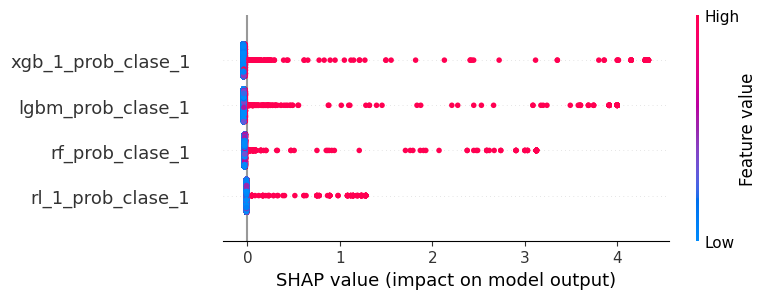

In [7]:
# Generamos predicciones de los modelos base que sirven como caracteristicas del meta-modelo
X_meta = stacking_model.transform(X_test)
feature_names = ['rf_prob_clase_1', 'xgb_1_prob_clase_1', 'rl_1_prob_clase_1', 'lgbm_prob_clase_1']
# El meta-modelo ya está entrenado dentro del StackingClassifier
meta_model_fitted = stacking_model.final_estimator_
# Instanciamos el LinearExplainer de shap para explicar la regresion logistica
explainer = shap.LinearExplainer(meta_model_fitted, X_meta)
# Calculamos los shap values
shap_values = explainer.shap_values(X_meta)
# Generamos shap values en DataFrame
X_meta_df = pd.DataFrame(X_meta, columns=feature_names, index=X_test.index)
# Resumen global de la importancia
shap.summary_plot(shap_values, X_meta_df, max_display=10)

# Explicación para una instancia
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_meta_df.iloc[0,:])

# Los coeficientes están en el atributo 'coef_'
meta_model_fitted = stacking_model.final_estimator_
coefficients = meta_model_fitted.coef_[0]

# Generamos DataFrame con el peso de cada modelo
model_weights = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [8]:
# Peso de cada modelo en las predicciones del meta-modelo
model_weights

,Feature,Coefficient
0,rf_prob_clase_1,3.170609
1,xgb_1_prob_clase_1,4.383209
2,rl_1_prob_clase_1,1.290926
3,lgbm_prob_clase_1,4.042037


In [24]:
# Peso por prediccion de clase 1
X_meta_df.iloc[10:20,:]

,rf_prob_clase_1,xgb_1_prob_clase_1,rl_1_prob_clase_1,lgbm_prob_clase_1
141828,0.000409,0.000043,0.000098,0.000028
147159,0.000262,0.000083,0.000673,0.000028
35678,0.000073,0.000021,0.000059,0.000263
209248,0.000069,0.000027,0.000059,0.000028
79709,0.000073,0.000060,0.000044,0.000028
231846,0.000101,0.000087,0.000396,0.000028
207725,0.000069,0.000058,0.000059,0.000028
268502,0.000143,0.000244,0.000059,0.000060
257623,0.000073,0.000047,0.000094,0.000028
214961,0.000069,0.000047,0.000000,0.000028


In [25]:
# añadimos a X_meta_df la prediccion del meta-modelo
X_meta_df['meta_model_pred_proba'] = stacking_model.final_estimator_.predict_proba(X_meta)[:, 1]

In [27]:
# añadimos a X_meta_df la clase real
X_meta_df['meta_model_class'] = stacking_model.final_estimator_.predict(X_meta)

In [29]:
# filtramos por meta_model_class == 1
X_meta_df[X_meta_df['meta_model_class'] == 1]

,rf_prob_clase_1,xgb_1_prob_clase_1,rl_1_prob_clase_1,lgbm_prob_clase_1,meta_model_pred_proba,meta_model_class
97339,0.995984,0.992593,0.962963,0.978723,0.992310,1
83959,0.759804,0.923148,0.847787,0.923077,0.968727,1
136867,0.663815,0.923148,0.894676,0.616049,0.875272,1
193310,0.791126,0.992593,0.847787,1.000000,0.984447,1
175468,0.995984,0.992593,1.000000,1.000000,0.993266,1
...,...,...,...,...,...,...
26602,0.565359,0.721419,0.698084,0.795833,0.772928,1
68168,0.995984,0.992593,0.962963,0.978723,0.992310,1
169616,0.995984,0.992593,0.847787,1.000000,0.991816,1
96985,0.995984,0.992593,1.000000,0.978723,0.992666,1


In [30]:
# filtramos por meta_model_class == 0
X_meta_df[X_meta_df['meta_model_class'] == 0]

,rf_prob_clase_1,xgb_1_prob_clase_1,rl_1_prob_clase_1,lgbm_prob_clase_1,meta_model_pred_proba,meta_model_class
130105,0.000294,0.000168,0.000094,0.000699,0.000392,0
79508,0.000259,0.000057,0.000064,0.000028,0.000391,0
82829,0.000069,0.000181,0.000094,0.000028,0.000391,0
42321,0.000259,0.000029,0.000074,0.000028,0.000391,0
41314,0.000644,0.001186,0.001518,0.002778,0.000399,0
...,...,...,...,...,...,...
161445,0.000590,0.000065,0.000059,0.000142,0.000392,0
119745,0.000441,0.000714,0.000673,0.000809,0.000394,0
4617,0.000073,0.000079,0.000059,0.000028,0.000391,0
262845,0.000069,0.000404,0.000232,0.000028,0.000391,0


In [18]:
# Probabilidad de ser un caso de fraude para una determinada transaccion
instancia_ejemplo_idx = 1
X_meta_df.iloc[instancia_ejemplo_idx]  


rf_prob_clase_1       0.000259
xgb_1_prob_clase_1    0.000057
rl_1_prob_clase_1     0.000064
lgbm_prob_clase_1     0.000028
Name: 79508, dtype: float64

#### <font color="Greenyellow">4.2 Explicabilidad modelos base</font>

##### <font color="Greenyellow">4.2.1 Explicabilidad XGBoost</font>

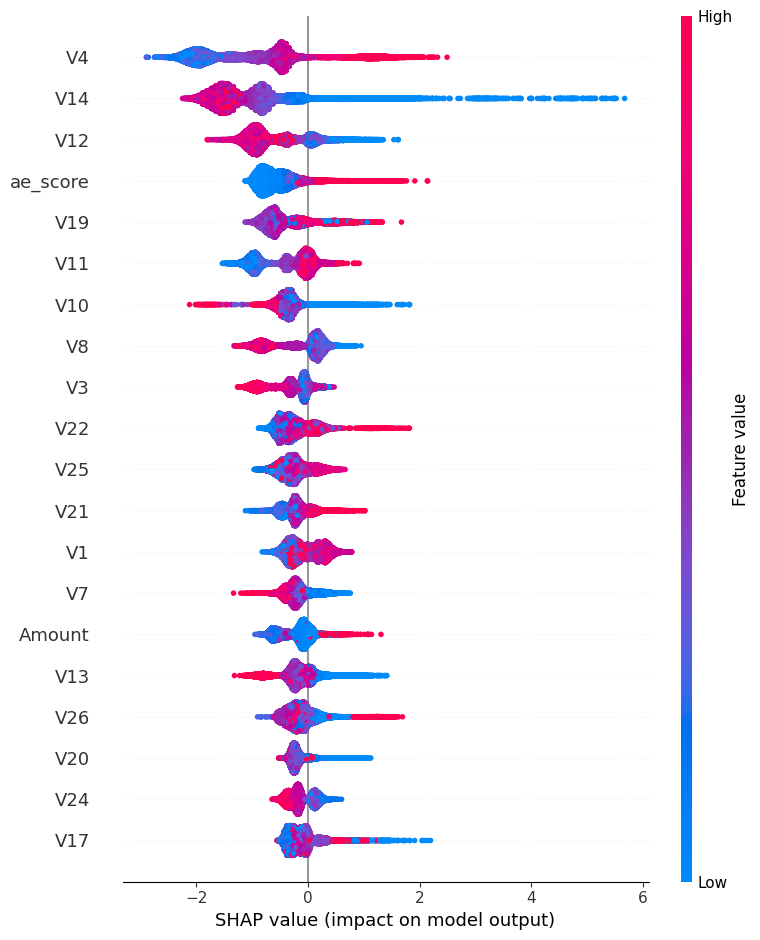

In [11]:
# Explicacion mediante valores shap del XGBoos que esta dentro del meta-modelo
# Modelo base a explicar que se encuentra dentro del StackingClassifier
calibrated_xgb_fitted = stacking_model.named_estimators_['xgb_1']

# Accedemos al modelo, el atributo puede ser estimator o base_estimator_
xgb_model_fitted = calibrated_xgb_fitted.calibrated_classifiers_[0].estimator

# Instanciamos el TreeExplainer de shap para explicar modelos basados en árboles
xgb_explainer = shap.TreeExplainer(xgb_model_fitted)

# Calculamos los shap values para clase 1
xgb_shap_values = xgb_explainer.shap_values(X_test)

# Graficamos valores Shap limiando el numero de valores a mostras a 10
shap.summary_plot(
    xgb_shap_values, 
    X_test, 
    show=False
)
plt.show()

##### <font color="Greenyellow">4.2.2 Explicabilidad LightGBM</font>

c:\Users\Nitropc\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


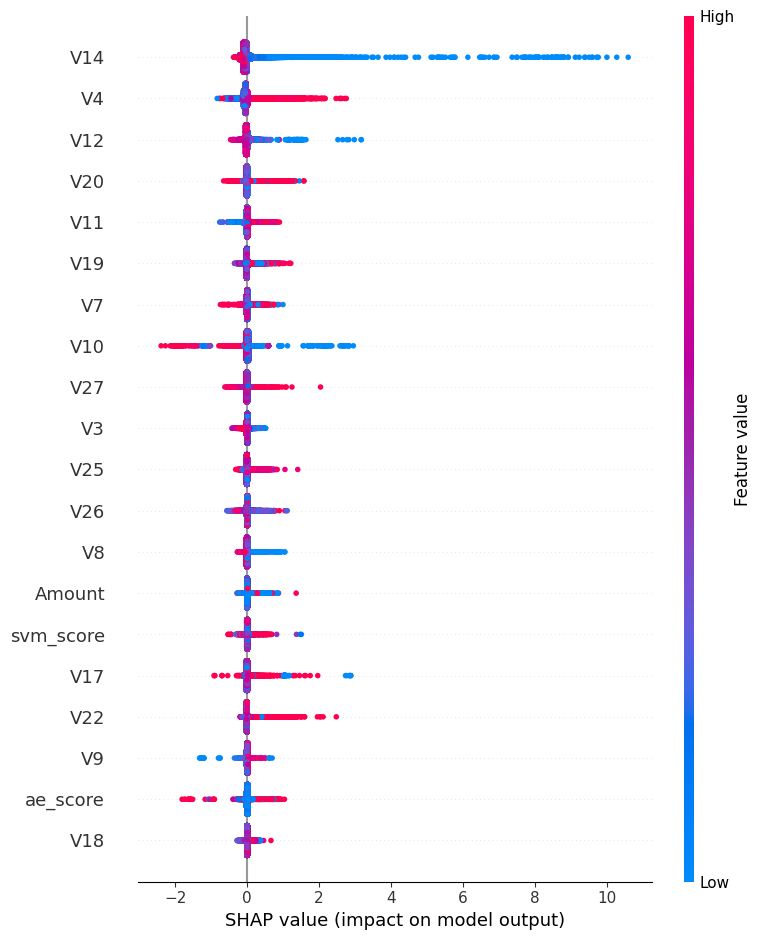

In [12]:
# Explicacion mediante valores shap del LightGBM que esta dentro del meta-modelo
# Modelo base a explicar que se encuentra dentro del StackingClassifier
calibrated_lgbm_fitted = stacking_model.named_estimators_['lgbm']

# Accedemos al modelo, el atributo puede ser estimator o base_estimator_
lgbm_model_fitted = calibrated_lgbm_fitted.calibrated_classifiers_[0].estimator

# Instanciamos el TreeExplainer de shap para explicar modelos basados en árboles
lgbm_explainer = shap.TreeExplainer(lgbm_model_fitted)

# Calculamos los shap values para clase 1
lgbm_shap_values = lgbm_explainer.shap_values(X_test)

# Graficamos valores Shap
shap.summary_plot(
    lgbm_shap_values,
    X_test,
    show=False
)
plt.show()

##### <font color="Greenyellow">4.2.3 Explicabilidad Random Forest</font>

In [13]:
# 1. Instanciamos el modelo de Arbol de decision
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=semilla)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model_dt, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model_dt.fit(X_train, y_train)
print("... entrenamiento completado.")

1. Entrenando el modelo...
... entrenamiento completado.


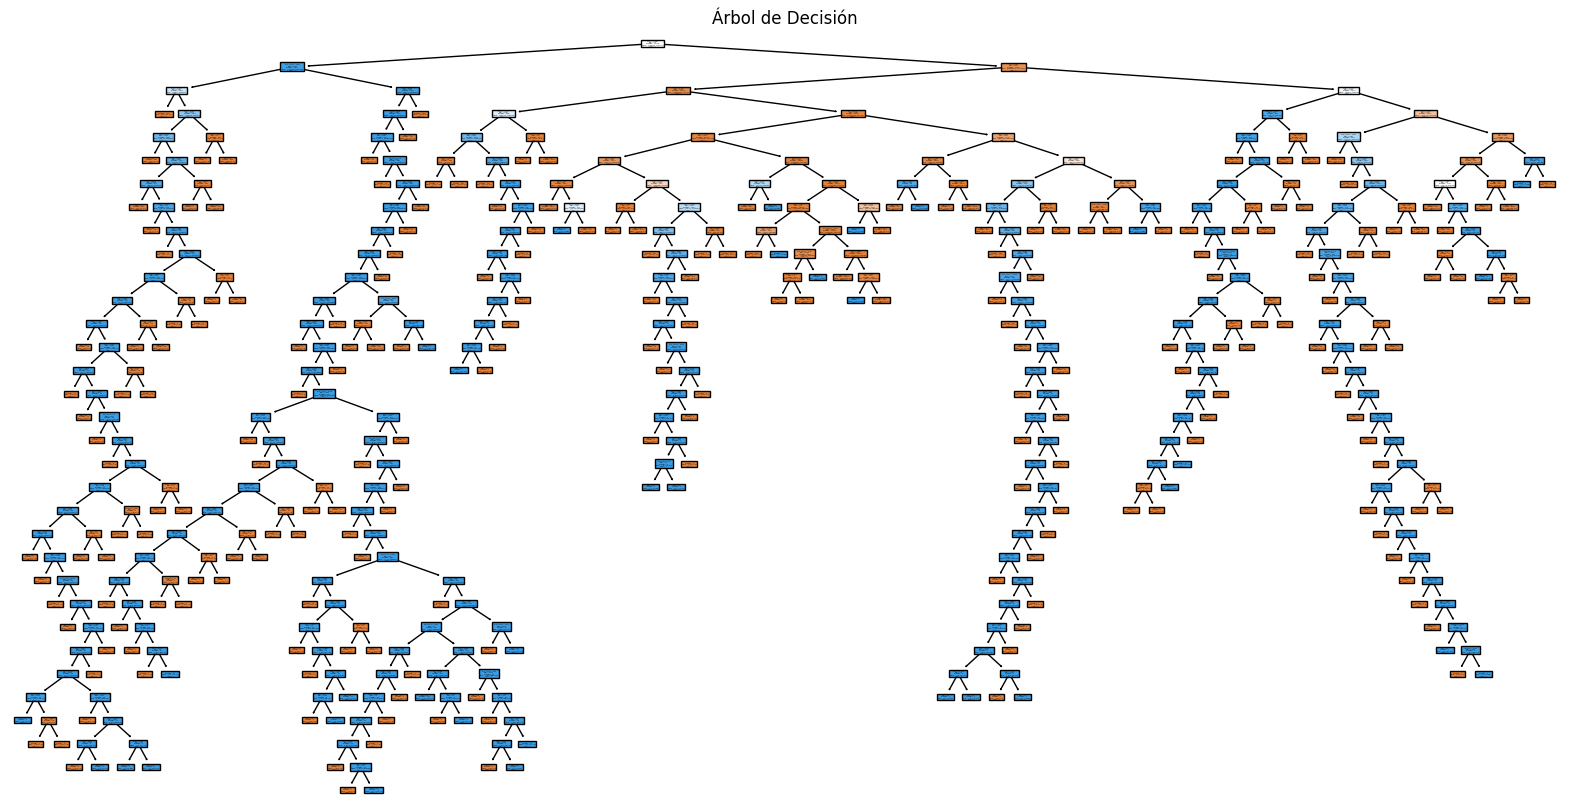

In [14]:
plt.figure(figsize=(20,10))
plot_tree(model_dt, filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.title("Árbol de Decisión")
plt.show()

Text(0.5, 1.0, 'Árbol de Decisión (2 primeros niveles)')

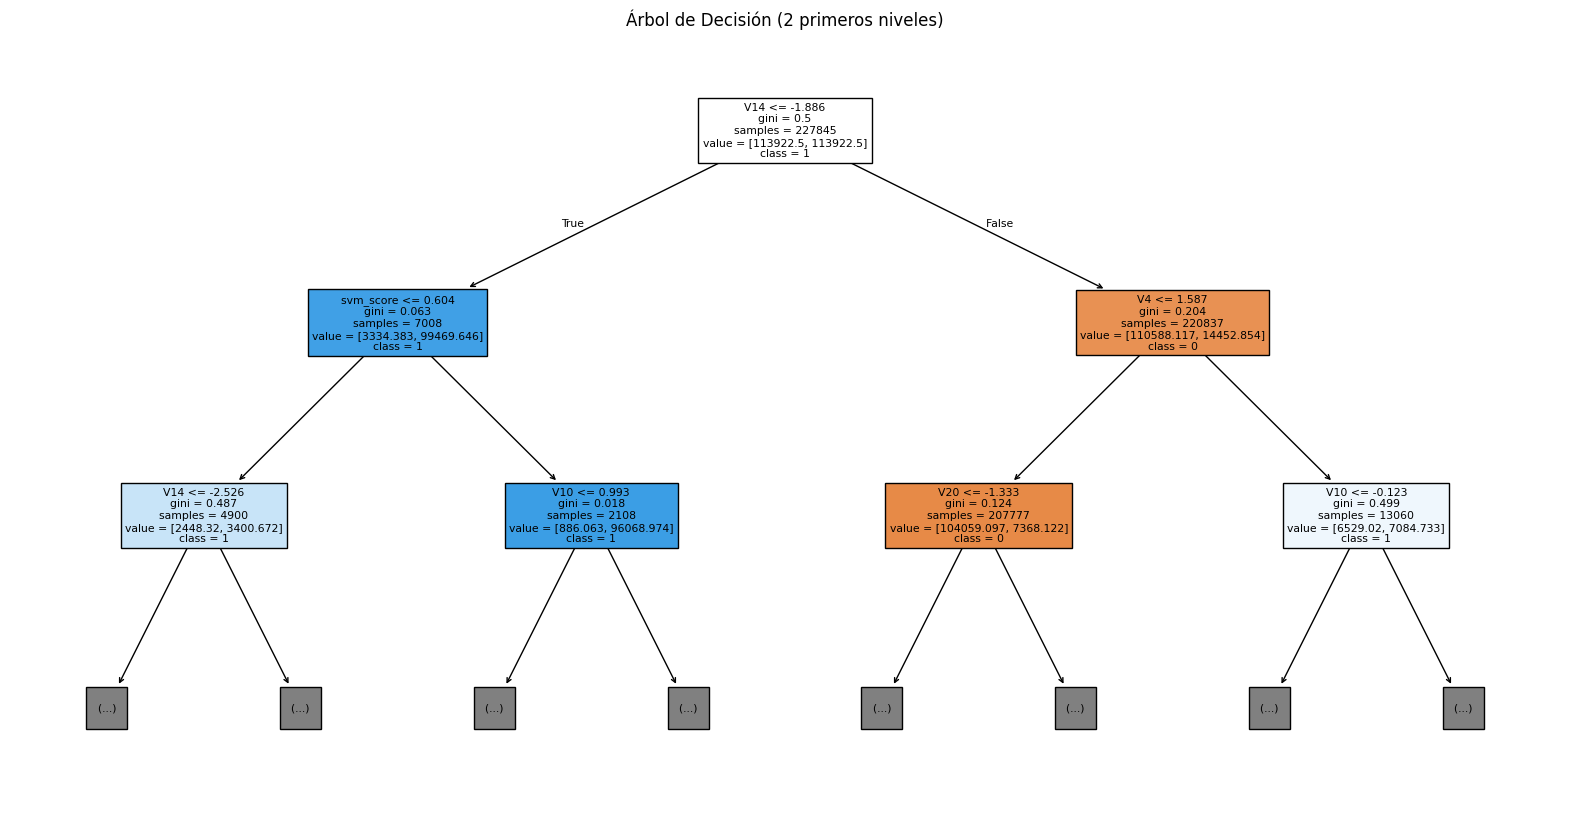

In [15]:
# Pintamos los 5 primeros niveles del arbol de decision
niveles = 2
plt.figure(figsize=(20,10))
plot_tree(model_dt, max_depth=niveles, filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.title(f"Árbol de Decisión ({niveles} primeros niveles)")

##### <font color="Greenyellow">4.2.4 Explicabilidad Regresión Logistica</font>

In [16]:
%%time
# 1. Instanciamos el modelo base (Regresión Logística)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
# 3. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(base_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 4. Entrenamos el modelo de ensamble
print("1. Entrenando el modelo...")
base_model.fit(X_train, y_train)
print("... entrenamiento completado.")

1. Entrenando el modelo...
... entrenamiento completado.
CPU times: total: 3.75 s
Wall time: 14.5 s


c:\Users\Nitropc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


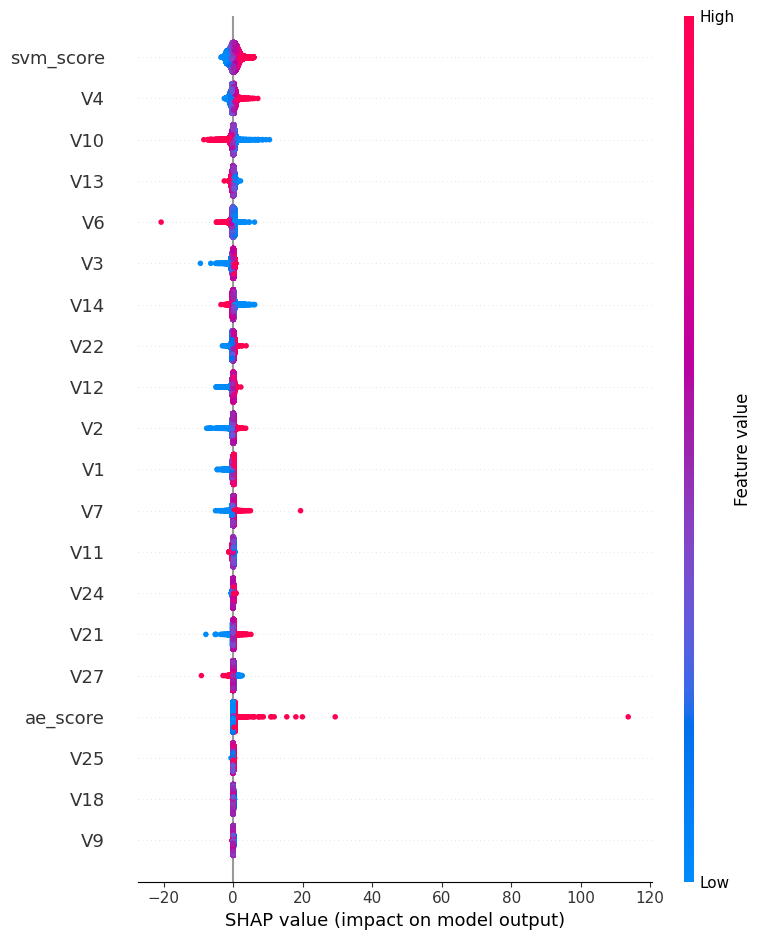

In [17]:
# Explicamos valores shap de base_model
explainer = shap.LinearExplainer(base_model, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values,
    X_test,
    show=False
)